In [ ]:
%%bigquery
CREATE OR REPLACE EXTERNAL TABLE `jc_demo_test.met_images`
WITH CONNECTION `jc-gcp-project.us.bigframes-rf-conn`
OPTIONS
  ( object_metadata = 'SIMPLE',
    uris = ['gs://gcs-public-data--met/*']
  );

Query is running:   0%|          |

""


#### Image in bucket
https://console.cloud.google.com/storage/browser/gcs-public-data--met

https://cloud.google.com/bigquery/docs/generate-multimodal-embeddings?_gl=1*1wju6ou*_ga*MTc1NjMyMDg1Mi4xNjc4OTIyMjMx*_ga_WH2QY8WWF5*MTcxNTIwNjE5NS41NzEuMS4xNzE1MjA2NDczLjAuMC4w&_ga=2.249427399.-1756320852.1678922231&hl=ko


In [ ]:
#@title Set up credentials
from google.colab import auth
auth.authenticate_user()
print('Authenticated')
PROJECT_ID='jc-gcp-project'
from google.cloud import bigquery
client = bigquery.Client(PROJECT_ID)

Authenticated


In [ ]:
#@title Enable data table display
%load_ext google.colab.data_table

In [ ]:
#@title Util function to display images
import io
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf

def printImages(results):
 image_results_list = list(results)
 amt_of_images = len(image_results_list)

 fig, axes = plt.subplots(nrows=amt_of_images, ncols=2, figsize=(20, 20))
 fig.tight_layout()
 fig.subplots_adjust(hspace=0.5)
 for i in range(amt_of_images):
   gcs_uri = image_results_list[i][0]
   text = image_results_list[i][1]
   f = tf.io.gfile.GFile(gcs_uri, 'rb')
   stream = io.BytesIO(f.read())
   img = Image.open(stream)
   axes[i, 0].axis('off')
   axes[i, 0].imshow(img)
   axes[i, 1].axis('off')
   axes[i, 1].text(0, 0, text, fontsize=10)
 plt.show()

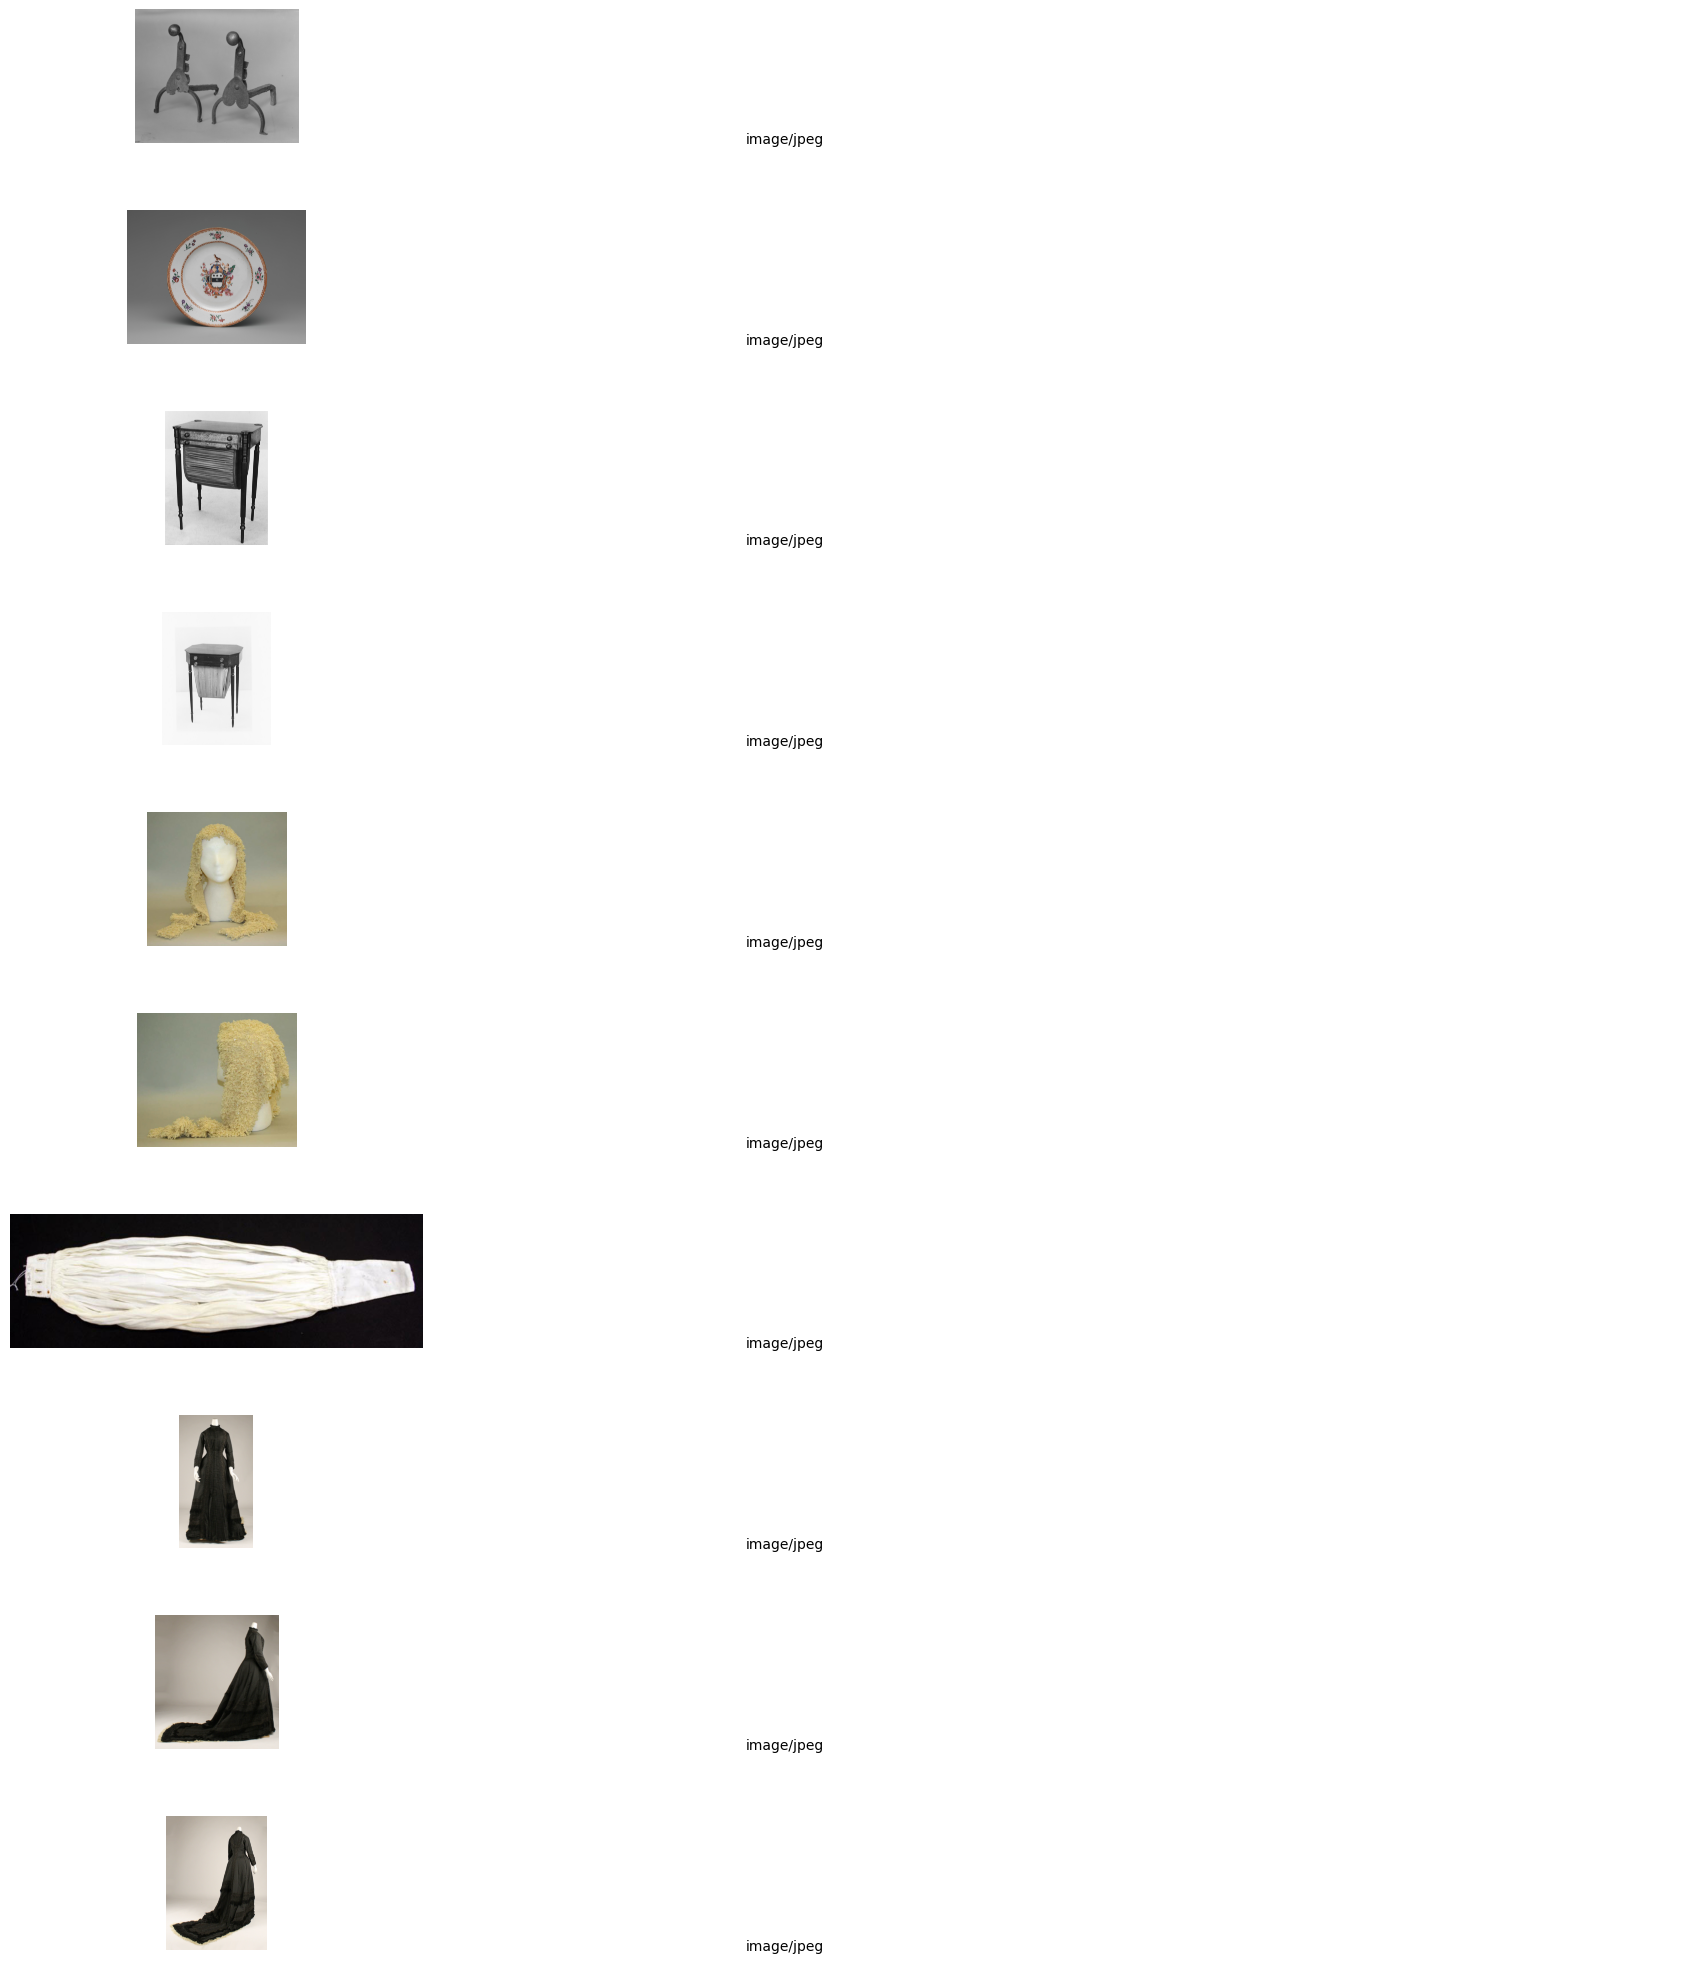

In [ ]:
#@title Display Met images

inspect_obj_table_query = """
SELECT uri, content_type
FROM jc_demo_test.met_images
WHERE content_type = 'image/jpeg'
Order by uri
LIMIT 10;
"""
printImages(client.query(inspect_obj_table_query))

## 원격 모델 만들기

In [ ]:
%%bigquery
CREATE OR REPLACE MODEL `jc_demo_test.multimodal_embedding_model`
  REMOTE WITH CONNECTION `jc-gcp-project.us.bigframes-rf-conn`
  OPTIONS (ENDPOINT = 'multimodalembedding@001');

Query is running:   0%|          |

""


## 이미지 임베딩 생성

In [ ]:
%%bigquery
CREATE OR REPLACE TABLE `jc_demo_test.met_image_embeddings`
AS
SELECT *
FROM
  ML.GENERATE_EMBEDDING(
    MODEL `jc_demo_test.multimodal_embedding_model`,
    TABLE `jc_demo_test.met_images`)
WHERE content_type = 'image/jpeg'
LIMIT 10000;

Query is running:   0%|          |

""


#### 오류확인 (Optional)

In [ ]:
%%bigquery
SELECT DISTINCT(ml_generate_embedding_status),
  COUNT(uri) AS num_rows
FROM jc_demo_test.met_image_embeddings
GROUP BY 1;

Query is running:   0%|          |

Downloading:   0%|          |

,ml_generate_embedding_status,num_rows
0,,10000


#### 오류 발견시 삭제

In [ ]:
%%bigquery
DELETE FROM `jc_demo_test.met_image_embeddings`
WHERE ml_generate_embedding_status = 'A retryable error occurred: RESOURCE_EXHAUSTED error from remote service/endpoint.';

## Vector Indexing

In [ ]:
%%bigquery
CREATE OR REPLACE
  VECTOR INDEX `met_images_index`
ON
  jc_demo_test.met_image_embeddings(ml_generate_embedding_result)
  OPTIONS (
    index_type = 'IVF',
    distance_type = 'COSINE');

Query is running:   0%|          |

""


#### Check Indexing (optional)

In [ ]:
%%bigquery
SELECT table_name, index_name, index_status,
  coverage_percentage, last_refresh_time, disable_reason
FROM jc_demo_test.INFORMATION_SCHEMA.VECTOR_INDEXES
WHERE index_name = 'met_images_index';

Query is running:   0%|          |

Downloading:   0%|          |

,table_name,index_name,index_status,coverage_percentage,last_refresh_time,disable_reason
0,met_image_embeddings,met_images_index,ACTIVE,0,NaT,None


## Get Text Information

In [ ]:
%%bigquery
CREATE OR REPLACE TABLE `jc_demo_test.search_embedding`
AS
SELECT * FROM ML.GENERATE_EMBEDDING(
  MODEL `jc_demo_test.multimodal_embedding_model`,
  (
    SELECT '원목으로 만들어진 테이블' AS content
  )
);

Query is running:   0%|          |

""


In [ ]:
#

Query is running:   0%|          |

""


In [ ]:
#@title Search thru Image (option2 - 이부분은 검색 텍스트 대신 이미지 URI를 Input으로 넣는 부분입니다)
# %%bigquery
# CREATE OR REPLACE TABLE `jc_demo_test.search_embedding_image_raw` AS
# SELECT *
# FROM `jc_demo_test.met_images`
# WHERE content_type = 'image/jpeg'
# LIMIT 1;

%%bigquery
CREATE OR REPLACE TABLE `jc_demo_test.search_embedding_image`
AS
SELECT *
FROM
  ML.GENERATE_EMBEDDING(
    MODEL `jc_demo_test.multimodal_embedding_model`,
    (SELECT uri AS content from `jc_demo_test.search_embedding_image_raw`)
);

Query is running:   0%|          |

""


## Multimodal Test

In [ ]:
%%bigquery
CREATE OR REPLACE TABLE `jc_demo_test.vector_search_results` AS
SELECT base.uri AS gcs_uri, distance
FROM
  VECTOR_SEARCH(
    TABLE `jc_demo_test.met_image_embeddings`,
    'ml_generate_embedding_result',
    TABLE `jc_demo_test.search_embedding`,
    'ml_generate_embedding_result',
    top_k => 3);

Query is running:   0%|          |

""


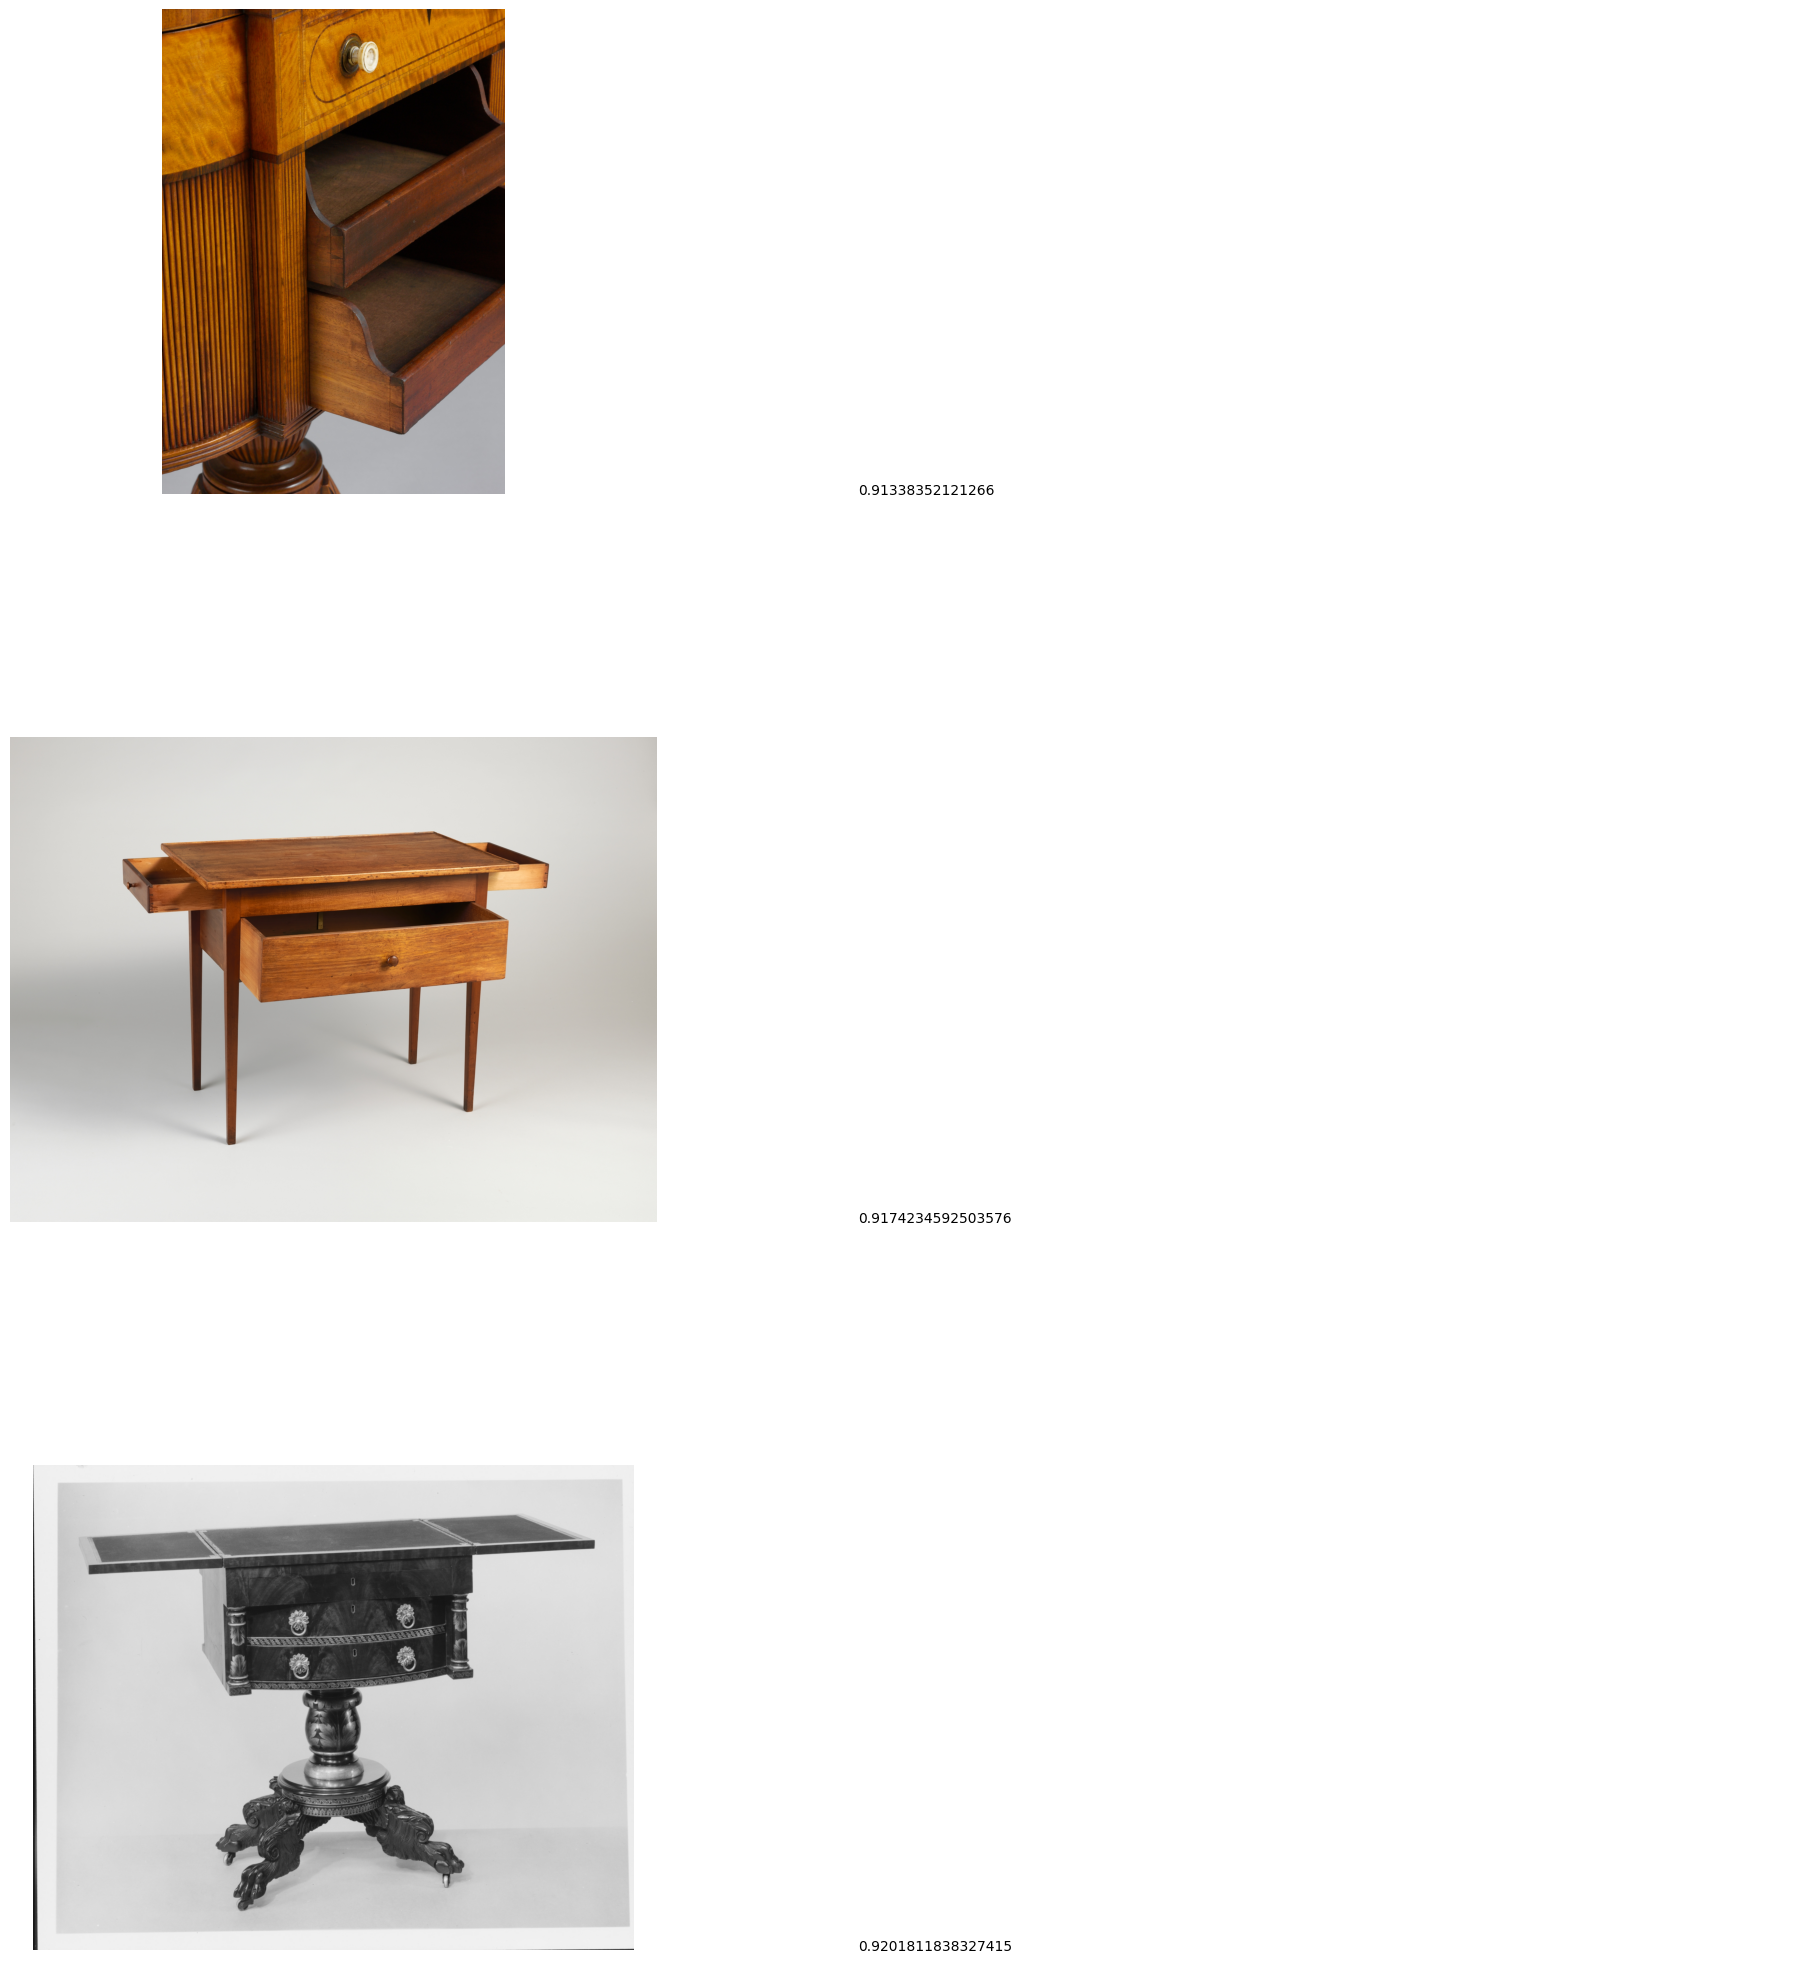

In [ ]:
query = """
  SELECT * FROM `jc_demo_test.vector_search_results`
  ORDER BY distance;
"""

printImages(client.query(query))

In [ ]:
#@title Search thru Image (option2 - 이미지 Input으로 같은 이미지 찾기)
%%bigquery
CREATE OR REPLACE TABLE `jc_demo_test.vector_search_results_image` AS
SELECT base.uri AS gcs_uri, distance
FROM
  VECTOR_SEARCH(
    TABLE `jc_demo_test.met_image_embeddings`,
    'ml_generate_embedding_result',
    TABLE `jc_demo_test.search_embedding_image`,
    'ml_generate_embedding_result',
    top_k => 3);

Query is running:   0%|          |

""


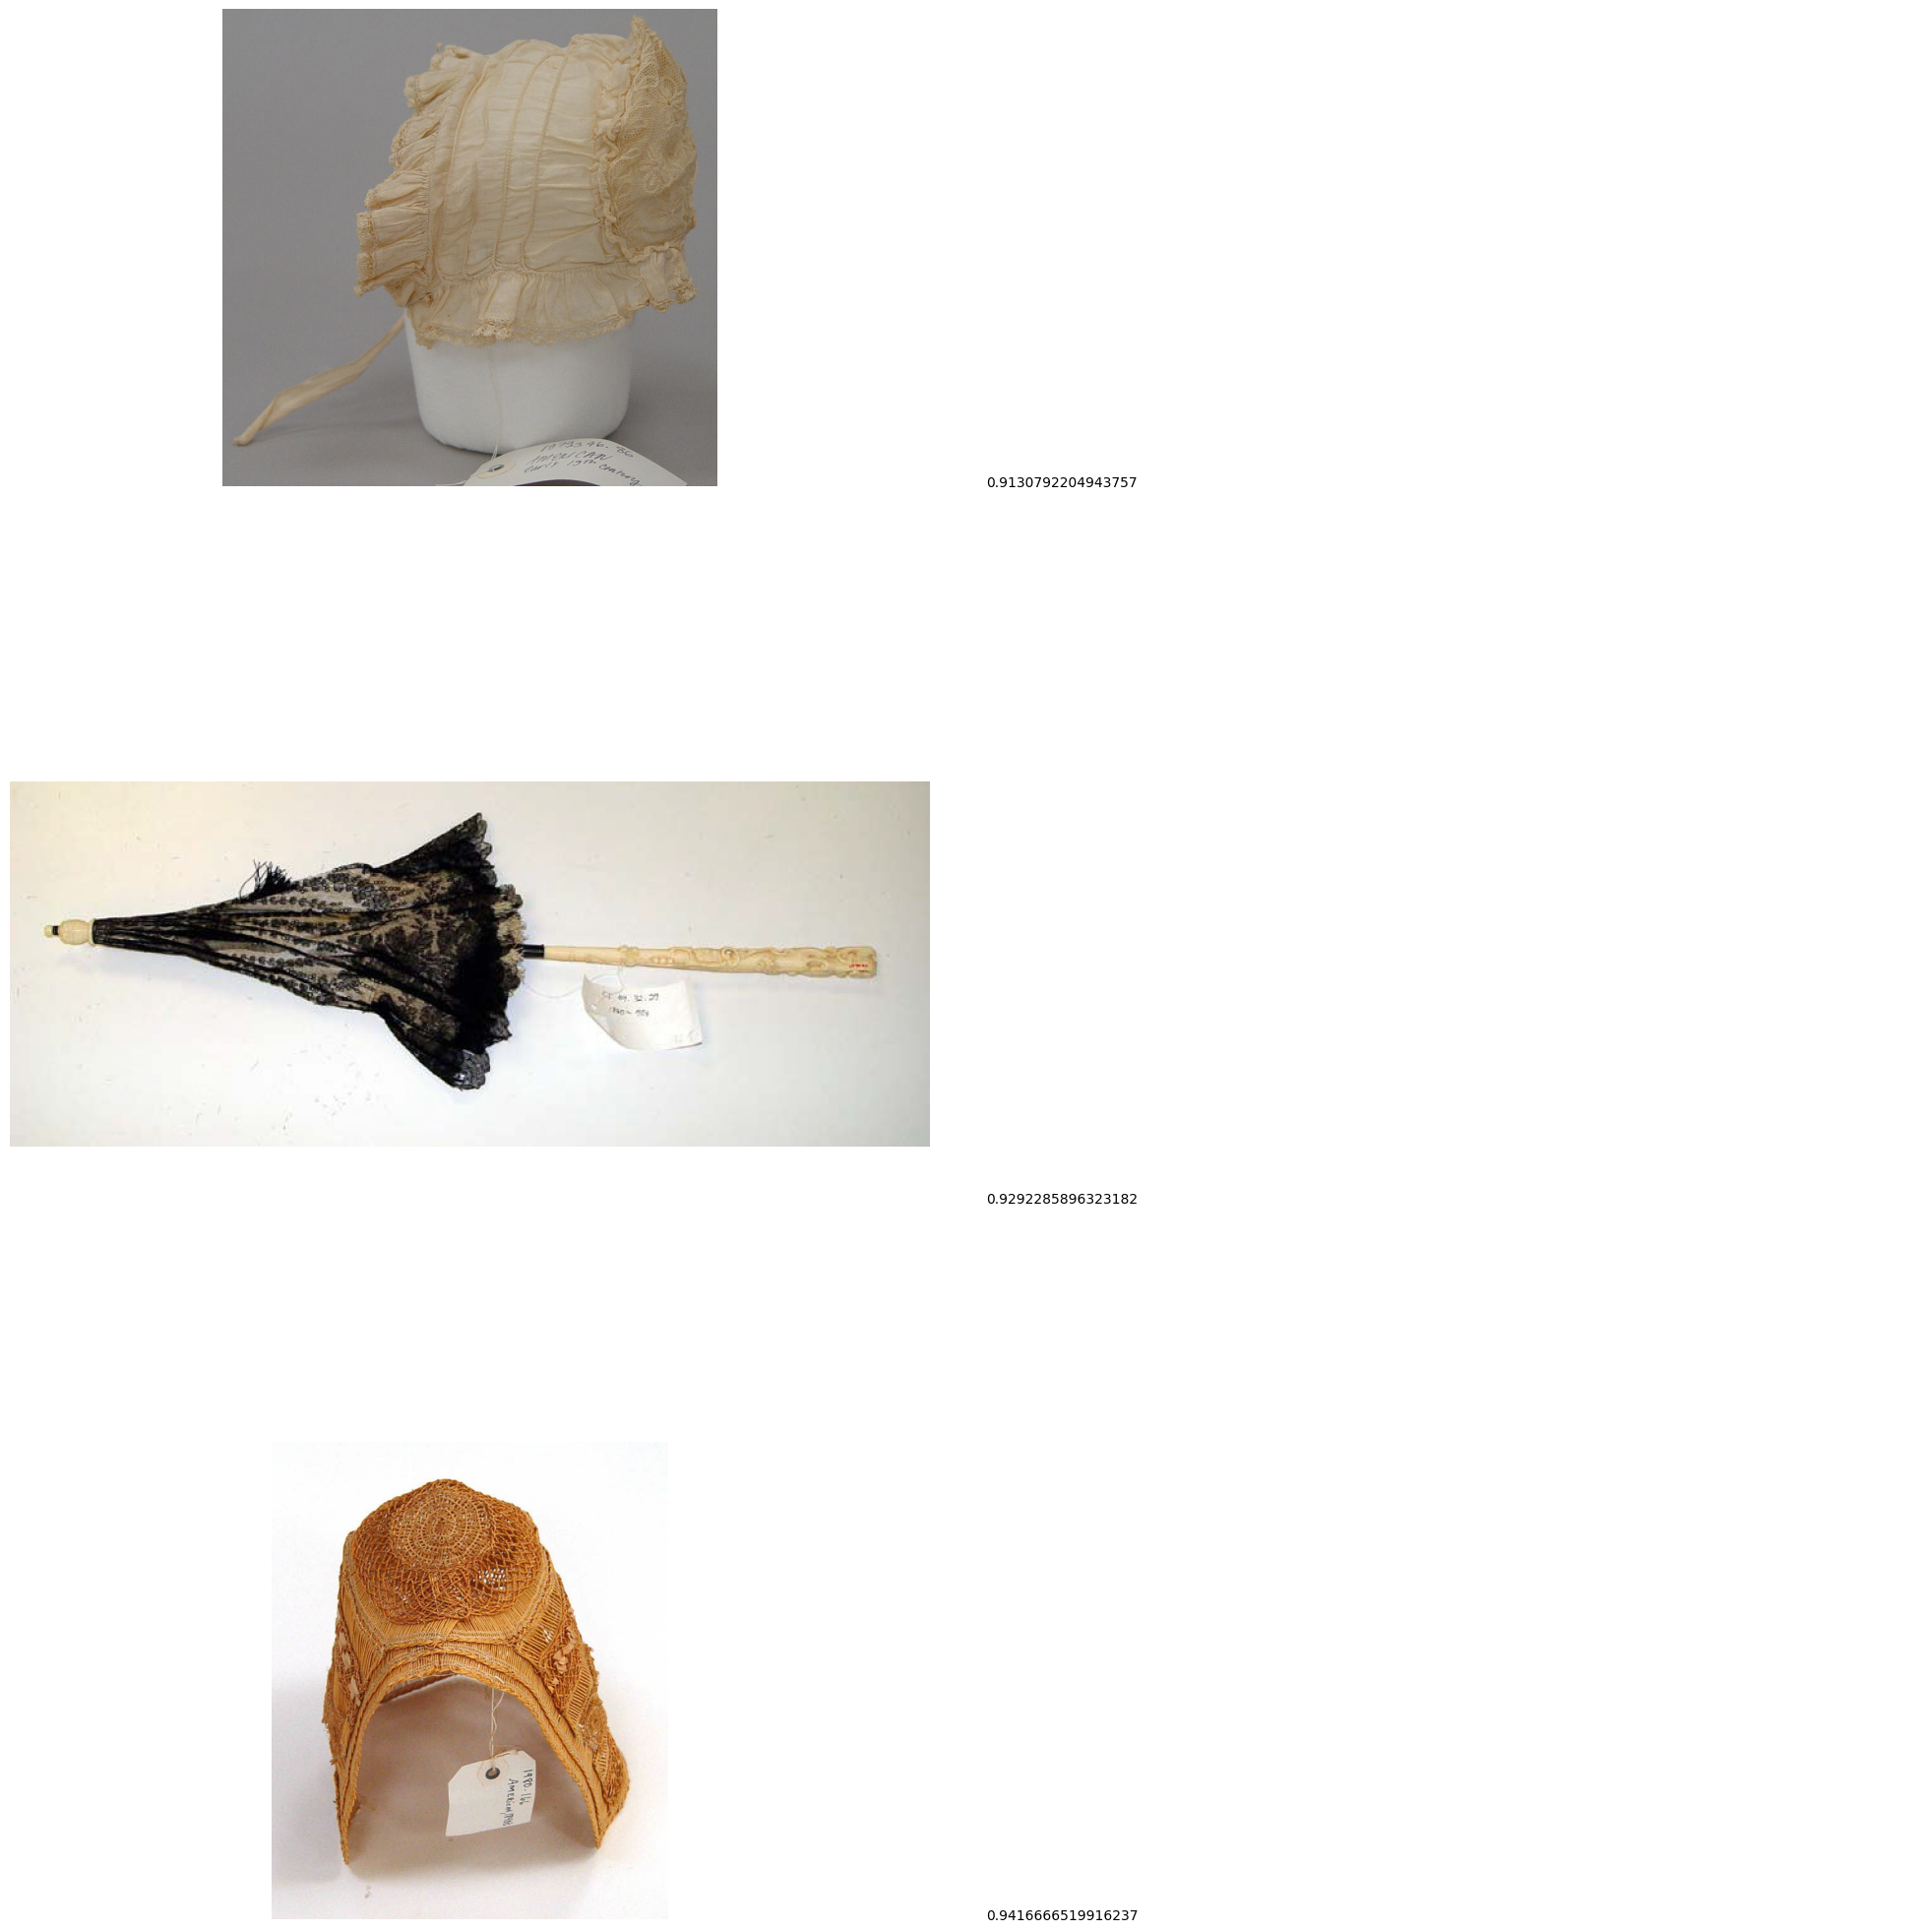

In [ ]:
# Option 2 (option2 - 이미지 결과 확인)
query = """
  SELECT * FROM `jc_demo_test.vector_search_results_image`
  ORDER BY distance;
"""

printImages(client.query(query))

In [ ]:
# Option 2 (option2 - 후처리에 사용하기 위해 메타 넣어줘야할 테이블)
%%bigquery
SELECT * FROM `jc_demo_test.vector_search_results_image` ORDER BY distance

Query is running:   0%|          |

Downloading:   0%|          |

,gcs_uri,distance
0,gs://gcs-public-data--met/104213/0.jpg,0.913079
1,gs://gcs-public-data--met/102266/1.jpg,0.929229
2,gs://gcs-public-data--met/104220/1.jpg,0.941667
